In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
from sklearn import metrics
from sklearn.metrics import confusion_matrix


cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from torch.autograd import Variable
from PIL import Image
toTensor = transforms.ToTensor()

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.is_available()

True

In [5]:
device

device(type='cuda', index=0)

In [6]:
class_names

['Not_Signature_card', 'Signature_card']

In [7]:
t_loss = []
v_loss = []

actual = []
pred = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
#                     outputs = outputs.cpu()
#                     index = outputs.data.numpy().argmax()
#                     pred.append(index)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                t_loss.append(epoch_loss)
            else:
                v_loss.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /home/anim/.cache/torch/hub/pytorch_vision_v0.10.0
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anim/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0279 Acc: 0.9897
val Loss: 0.0942 Acc: 0.9943

Epoch 1/4
----------
train Loss: 0.0153 Acc: 0.9947
val Loss: 0.0655 Acc: 0.9957

Epoch 2/4
----------
train Loss: 0.0119 Acc: 0.9972
val Loss: 0.0615 Acc: 0.9957

Epoch 3/4
----------
train Loss: 0.0100 Acc: 0.9972
val Loss: 0.0596 Acc: 0.9957

Epoch 4/4
----------
train Loss: 0.0104 Acc: 0.9984
val Loss: 0.0487 Acc: 0.9957

Training complete in 3m 16s
Best val Acc: 0.995714


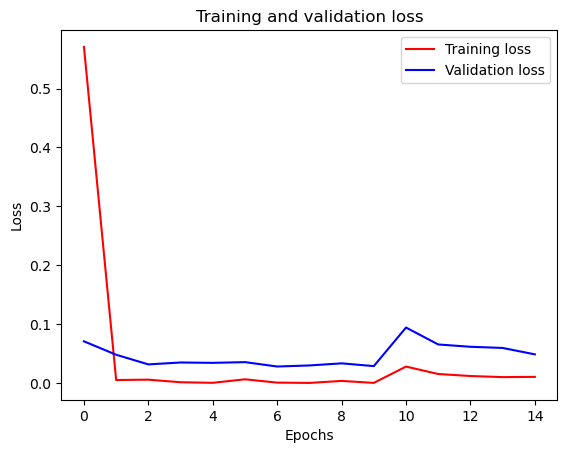

In [31]:
plt.plot( t_loss, 'r', label='Training loss')
plt.plot(v_loss, 'b', label='Validation loss')

# plt.plot(best_epoch_train_loss, 'g', label='Best loss')
# plt.plot( train_loss_arr, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
torch.save(model_ft.state_dict(), 'best_model/model03.pt')

In [33]:
torch.cuda.empty_cache()

In [13]:
model_state_dict = torch.load('best_model/model03.pt')

# model_state_dict = torch.load('best_model/model03.pt' , map_location=torch.device('cpu'))    ##for cpu only

model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft.load_state_dict(model_state_dict)
model_ft.eval()
model_ft.to(device)

Using cache found in /home/anim/.cache/torch/hub/pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
# Define a transformation to preprocess the image
pred_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a function for making predictions
def predict_class(image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Apply the defined transformation
    image_tensor = pred_transform(Image.fromarray(image))
    image_tensor = image_tensor.unsqueeze(0)  # Add a batch dimension
    
    # Move the input image to the same device as the model
    image_tensor = image_tensor.to(device)
    
    # Make a prediction
    with torch.no_grad():
        outputs = model_ft(image_tensor)
    
    # Get the predicted class index
    _, predicted_idx = torch.max(outputs, 1)
    
    # Map the class index to the class name (replace 'class_mapping' with your mapping)
    # class_mapping = {0: 'class_0', 1: 'class_1', 2: 'class_2'}  # Replace with your actual class names
    predicted_class = class_names[predicted_idx.item()]
    
    return predicted_class

In [26]:
predict_class("demo_img/9871.png")

'Not_Signature_card'

In [27]:
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder('dataset/test', transform=val_transforms)

valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [29]:
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

In [30]:
tp = cm[0, 0]
fp = cm[1, 0]
fn = cm[0, 1]
tn = cm[1, 1]

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision.item())
print("Recall:", recall.item())
print("F1 Score:", f1_score.item())

print(tp)
print(fp)
print(fn)
print(tn)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
200
0
0
200


In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

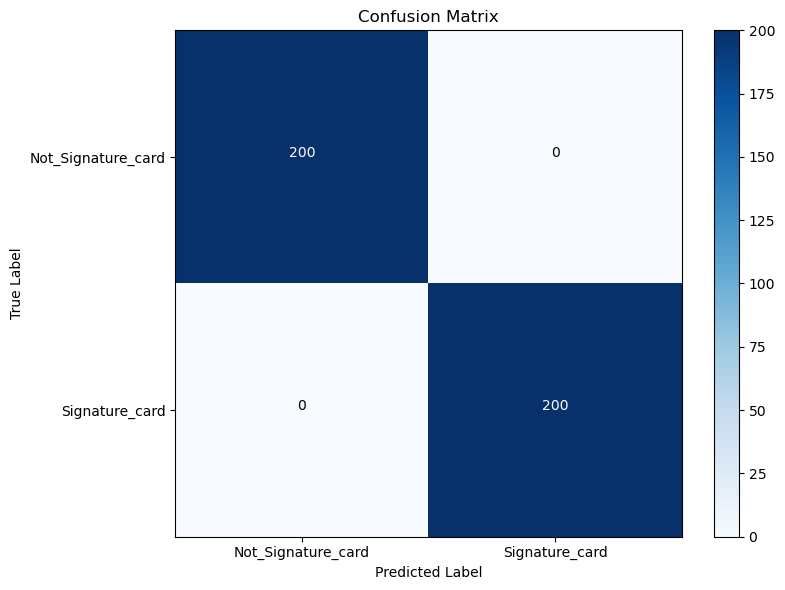

In [32]:
# Example confusion matrix values
confusion_matrix = np.array([[50, 10], [15, 75]])
classes = class_names

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes, normalize=False)
plt.show()

accuracy test


In [39]:
real_label = []
pred_label = []

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_label.append(labels)
            pred_label.append(predicted)
    return correct / total

In [40]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([255,255])
])

tests_path = r'dataset/test'

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 100
)

In [41]:
accuracy = evaluate(model_ft, test_dataloader)
accuracy


0.835